# Mapping barcodes and promoters

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [1]:
using wgregseq, CSV, DataFrames, Glob, BioSequences, CairoMakie, Statistics

# Set plotting style
wgregseq.plotting_style.default_makie!()

In [3]:
# Import table with custom function for correct column types
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")

# Take promoter sequence from oligo
promoter_seqs = [seq[27:196] for seq in df_seqs.sequence]

# Add promoter sequence to table
insertcols!(df_seqs, 4, :promoter_seq => [x[27:186] for x in df_seqs.sequence])

first(df_seqs, 5)

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


In [66]:
df_wt = df_seqs[1:1501:178000, [:promoter, :promoter_seq]] 
proms = ["mglBp", "hdeAp2", "mtnp", "ybeDp", "cpxRp2", "galEp1", "ompFp"]

for prom in proms
    df[map(x -> x in df_wt[df_wt.promoter .== prom, :promoter_seq], df_wt.promoter_seq), :] |> println
end

2×2 DataFrame
 Row │ promoter  promoter_seq                      
     │ String    LongSequenc…                      
─────┼─────────────────────────────────────────────
   1 │ mglBp     CAACACGCCAGAATGCGGCGGCGATCACTAAC…
   2 │ mglBp2    CAACACGCCAGAATGCGGCGGCGATCACTAAC…
2×2 DataFrame
 Row │ promoter  promoter_seq                      
     │ String    LongSequenc…                      
─────┼─────────────────────────────────────────────
   1 │ hdeAp2    TTCCTAATTGCAGTATCTGATGCATCTGTAAC…
   2 │ hdeAp     TTCCTAATTGCAGTATCTGATGCATCTGTAAC…
2×2 DataFrame
 Row │ promoter  promoter_seq                      
     │ String    LongSequenc…                      
─────┼─────────────────────────────────────────────
   1 │ mtnp      CCTGCGGTGAACGGTAACGACGATGCCAGTTT…
   2 │ mtnp2     CCTGCGGTGAACGGTAACGACGATGCCAGTTT…
2×2 DataFrame
 Row │ promoter  promoter_seq                      
     │ String    LongSequenc…                      
─────┼─────────────────────────────────────────────
   1 │ ybeDp  

In [4]:
# Store twist sequences in dictionary
dict_twist_sequences = Dict(df_seqs.promoter_seq .=> df_seqs.promoter);
dict_twist_primer2 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer2);
dict_twist_primer3 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer3);

In [61]:
df.promoter_seq |> unique

112-element Vector{LongSequence{DNAAlphabet{4}}}:
 TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGC…ACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG
 TCCACATTGATTATTTGCACGGCGTCACACTTTGCTATG…TTTTTGGATGGAGTGAAACGATGGCGATTGCAATTGGCC
 GTGTTGCACCTCCCCAGAGAGCGGCGGATAATGCTGCGA…TACTGCAAGACTAAAATTAACATGACAAGTCTGGTTTCC
 CCAGTTTCATCATTCCATTTTATTTTGCGAGCGAGCGCA…ATCACCCGCGGCATTACCTGATTATGGAGTTCAATATGC
 AATTGCGCAACAAAAGTAAGATCTCGGTCATAAATCAAG…TCGCGGTGATTGTTACTTATTAAAACTGTCCTCTAACTA
 GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGT…AACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT
 TGGACTTAGCAATGGCTGCTCCTGGCACAAAGCGGACAG…TTGTAATTACAAGAGGTGTAAGACATGGGTAGCATTAAC
 TTCTGGTATTCGTTGAGATTACTCTGAATCGTGGCGCAC…CTACCTGTTGAAAACACGCGTGCCGGATATGTCAGCCTA
 ACACGGACATACGTTGTTATGGAAGAAGTCAAGCAGAGT…GCAACAGTACTGGGGTAACCTGGTACTGTTGTCCGTTTT
 GAAGAAGGGGTTGAATCGCAGGCTATTCTGGTGGCCGGA…AGTCAATTCAGGGTGGTGAATGTGAAACCAGTAACGTTA
 GCAGGCTGGATGTCAGGGTGTTGTATTGCCATTTCAGTA…GTGCGCTCAGTATAGGAAGGGTGTTTTCGGCTACAATCA
 GGTTAACAGCAGGCTGGATGTCAGGGTGTTGTATTGCCA…TTTTTATTGTGCGCTCAG

In [12]:
# Import data file
df = CSV.read(
    "../../../data/barcodes/20220514_mapping/per_gene/*_filtered.txt", 
    DataFrame,
    header=[:promoter, :barcode, :count, :name]
)

df = df[df.name .!= "*", :]

df_bc = combine(groupby(df, [:promoter, :name]), nrow)[:, [:nrow, :name, :promoter]]
insertcols!(df_bc, 1, :thresh => map(x -> x > 9, df_bc.nrow))

,thresh,nrow,name,promoter
,Bool,Int64,String,String
1,1,65,TSS_1414_storz_regulondb,GATGACGACAAACTCATTTAACTCATGGCTGCCGTACGAGACTGTGAGGGATCAGACGAGAACGCACTCACCATAAATGCCCAGTTTATTCATTTCCCTGATTTTTATGATGGGATGGATTACCATGATCACCCGGCTAAGTTTGTTTTTCACTTACTTG
2,1,61,TSS_1414_storz_regulondb,GATGACGACAAACTCATGCATCTCCTGGCTGCCGTCCGAGACAGTGTGTGGTCAGACGATAACGCACCCACGAAAAATGTGCAGTTTAATGATTTACCTGGATTTTATGACGGGATGAATGACCCTGTTCACCCGGTTAAGTTTGTTTTTCTCTTACTTA
3,1,86,TSS_1414_storz_regulondb,GATGACGACAAACTCATGCATCTCATGGCTGCGGTGCGAGCCTGCGAGTGGTCAGACGATATCCCACTTACCATAAATGTGCCGTTTTATGATTTCCATGGATTTTTAGACTGGATGGATTACCCTGATCACACGGTTAAGGTTGTCTTTCACATACTTG
4,1,75,TSS_1414_storz_regulondb,GAAGACGATAAACTCATTCATCTCATGGCTGCCGTATGAGACTCTGAGTGGTCAGACGATAATGTACTCACCATGAATGAGGAGTTTAATGACTACCCTGGATTTTACAACTGGATCGATAACCCTGATCACCCGGTTTAGTTTGTTTTTCACATACTTG
5,1,71,TSS_1414_storz_regulondb,GAAGACGAGAAACTCATTCATCTCATGACTGCTGTACGAGACTGTGAGTGGTCAGACGATAACTTACTCCCCATAAGTGTGCAACTTAATGATTTCCCTGGAATTTATGACTGGATGGATGACCCTGATCACCCGCATAAGTTTGTTTTTCACATACTAA
6,1,55,TSS_1414_storz_regulondb,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
7,1,84,TSS_1414_storz_regulondb,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
8,1,89,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG
9,1,60,TSS_1414_storz_regulondb,GATGACGACAAATTCGTTCATTTCATGGCAGCCGTACGAGATTGTAAGGTATCAGACGATAACGCACTCACCATAAATGGGCAGTTTTATGATTTCCCTGGATTTTTTCACTGGATGGATTACCCTGATCACCCGGTTAAGTTTCTTATTCACATAGTTG


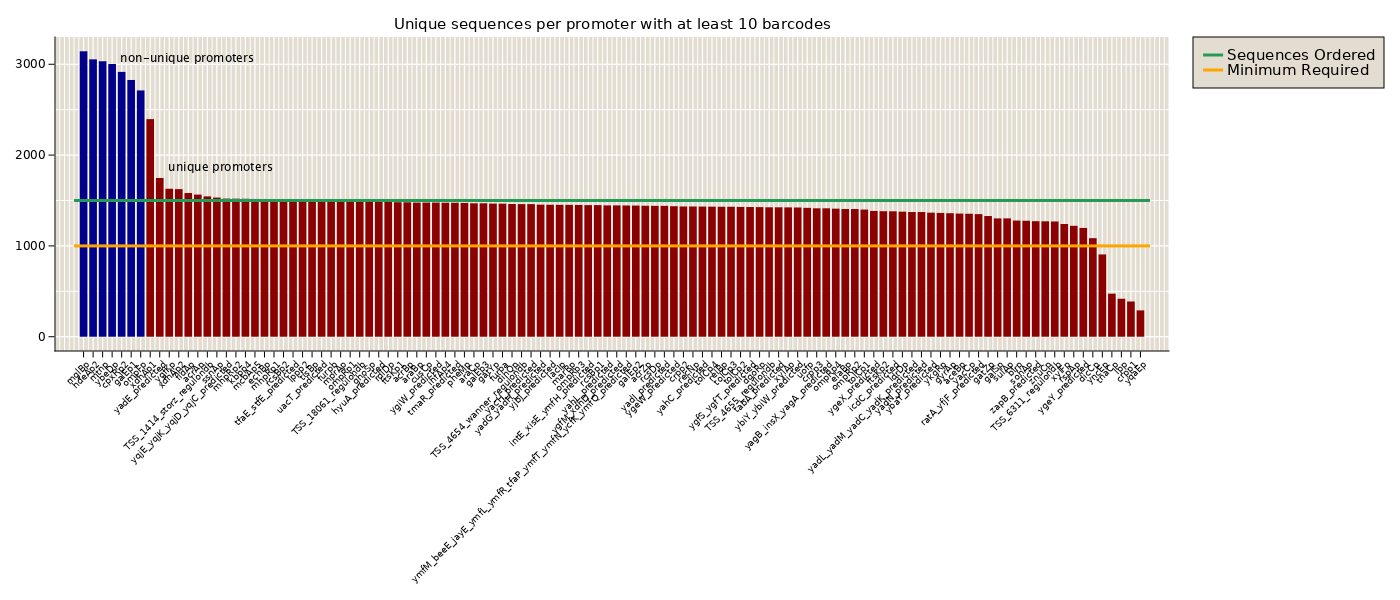

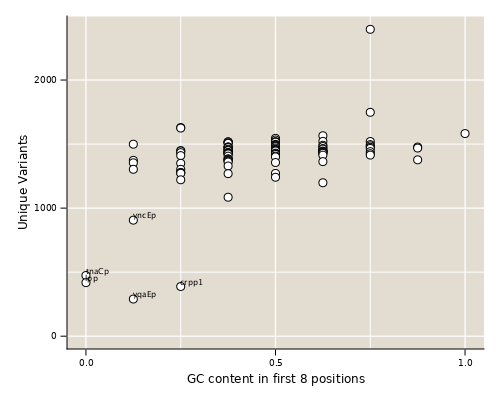

In [91]:
df_thresh = df_bc[df_bc.thresh .== 1, :]

num_unique(x) = length(unique(x))


df_unique = combine(groupby(df_thresh, :name), :promoter => num_unique);
df_unique = df_unique[df_unique.name .!= "None", :]
sort!(df_unique, :promoter_num_unique, rev=true)

# Remove empty ones
df_unique = df_unique[map(x -> x ∉  ["galEp", "ybeDp2"], df_unique.name), :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

color = map(x -> x in ["mglBp", "hdeAp2", "mtnp", "ybeDp", "cpxRp2", "galEp1", "ompFp"], df_unique.name)

barplot!(
    ax, 
    1:nrow(df_unique), 
    df_unique.promoter_num_unique,
    color=color,
    colormap=:redsblues
)

ax.xticks = (1:nrow(df_unique), df_unique.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter with at least 10 barcodes"
ax.titlesize=15
xlims!(-2, nrow(df_unique)+3)

maxi = lines!(ax, [0, nrow(df_unique)+1], [1500, 1500], color="#239b56", linewidth=3)
mini = lines!(ax, [0, nrow(df_unique)+1], [1000, 1000], color="orange", linewidth=3)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

text!(ax, "non-unique promoters", position=(5, 3000), textsize=12, font="Lucida Sans")
text!(ax, "unique promoters", position=(10, 1800), textsize=12, font="Lucida Sans")
save("../../../figures/unique_bc_prom.pdf", fig)
display(fig)


gc_l = 8
insertcols!(df_unique, 2, :wt_sequence => [df_wt[df_wt.promoter .== x, :promoter_seq][1] for x in df_unique.name])
insertcols!(df_unique, 2, :gc_content => [gc_content(x[1:gc_l]) for x in df_unique.wt_sequence])

fig = Figure(resolution=(500, 400))
ax = Axis(fig[1, 1])
scatter!(ax, df_unique.gc_content, df_unique.promoter_num_unique, markersize=8, color="white", strokewidth=1, strokecolor="black")
ax.ylabel = "Unique Variants"
ax.xlabel = "GC content in first $(gc_l) positions"
ylims!(ax, -100, 2500)

for i in 1:nrow(df_unique)
    if df_unique[i, :promoter_num_unique] < 1000
        text!(ax, df_unique[i, :name], position=(df_unique[i, :gc_content], df_unique[i, :promoter_num_unique]), textsize=8, font="Lucida Sans")
    end
end

display(fig)



In [64]:

gc_content(x) = sum([y in [DNA_C, DNA_G] for y in x]) / length(x)

0.6666666666666666

In [ ]:
["mglBp", "hdeAp2", "mtnp", "ybeDp", "cpxRp2", "galEp1", "ompFp", "xdhAp1"]

In [17]:
df_unique

,name,promoter_num_unique
,String,Int64
1,mglBp,3143
2,hdeAp2,3054
3,mtnp,3033
4,ybeDp,3003
5,cpxRp2,2916
6,galEp1,2827
7,ompFp,2712
8,xdhAp1,2396
9,yadE_predicted,1748
